In [54]:
import pm4py 
import pandas as pd

In [55]:
filepath = '/Users/nick/BPPSO/BPI Challenge 2017.xes'
log_concrete = pm4py.read_xes(filepath,return_legacy_log_object=True )

parsing log, completed traces ::   0%|          | 0/31509 [00:00<?, ?it/s]

In [56]:
df = pm4py.convert_to_dataframe(log_concrete)

In [57]:
grouped_df = df.groupby('case:concept:name')

trace_durations = (grouped_df['time:timestamp'].max() - 
                   grouped_df['time:timestamp'].min()).dt.total_seconds()

trace_lengths = grouped_df.size()

trace_features_df = pd.DataFrame({
    'Total_Time_Seconds': trace_durations,
    'Trace_Length': trace_lengths
})

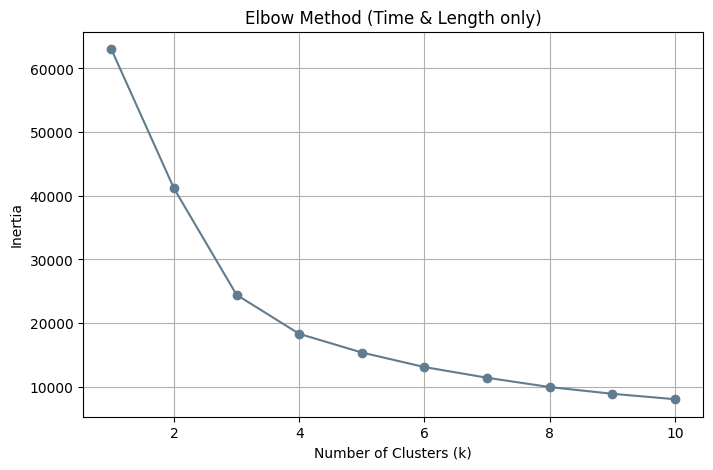

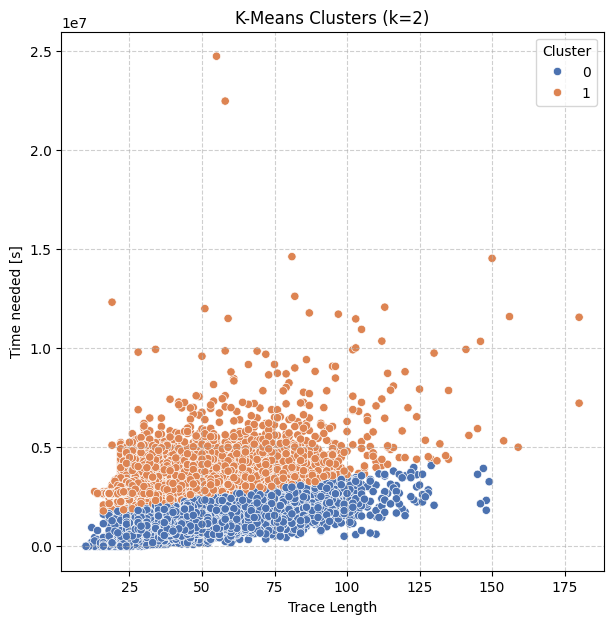

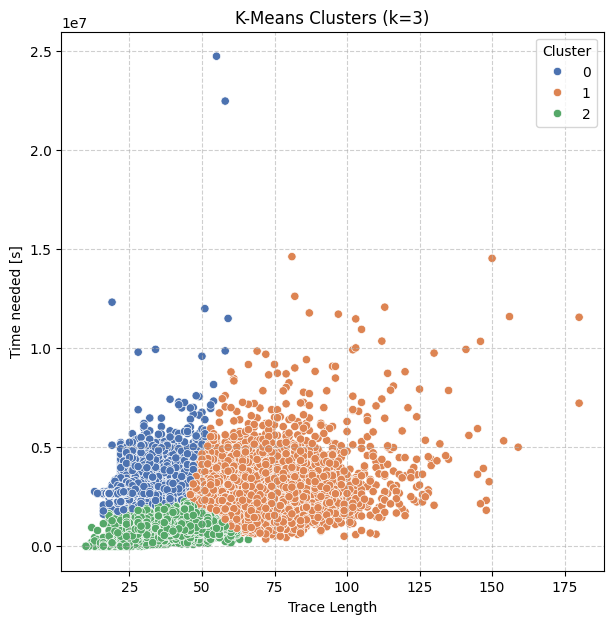

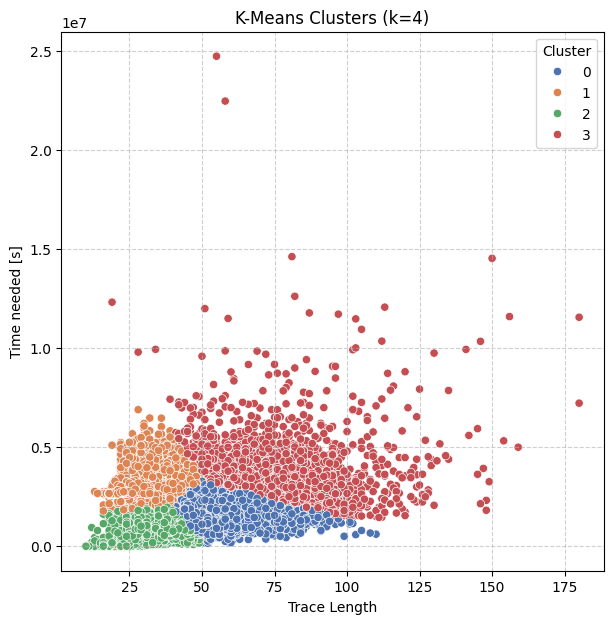

In [100]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns


# Feature selection
X_perf = trace_features_df

# Scale the data
scaler_perf = StandardScaler()
X_perf_scaled = scaler_perf.fit_transform(X_perf)

# Elbow Method
inertia_perf = []
k_range_perf = range(1, 11)

for k in k_range_perf:
    model = KMeans(n_clusters=k, n_init=10, random_state=42)
    model.fit(X_perf_scaled)
    inertia_perf.append(model.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range_perf, inertia_perf, marker='o',color='#607c8e')
plt.title('Elbow Method (Time & Length only)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.savefig('/Users/nick/BPPSO/figures/Elbow_plot_performance_I.png')
plt.show() 

for k in range(2,5):
    chosen_k_perf = k  

    final_model_perf = KMeans(n_clusters=chosen_k_perf, n_init=10, random_state=42)
    cluster_labels_perf = final_model_perf.fit_predict(X_perf_scaled)

    X_perf_plot = X_perf.copy()
    X_perf_plot['Cluster'] = cluster_labels_perf

    plt.figure(figsize=(7, 7))
    sns.scatterplot(
        data=X_perf_plot,
        x='Trace_Length',
        y='Total_Time_Seconds',
        hue='Cluster',       
        palette='deep'       
    )

    plt.title(f'K-Means Clusters (k={chosen_k_perf})')
    plt.xlabel('Trace Length')
    plt.ylabel('Time needed [s]')
    plt.legend(title='Cluster')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.savefig(f'/Users/nick/BPPSO/figures/cluster_plot_I_{chosen_k_perf}.png')
    plt.show()

In [95]:
activity_counts_df = df.groupby('case:concept:name')['concept:name'] \
                          .value_counts() \
                          .unstack(fill_value=0)

In [96]:
X_activities = activity_counts_df

In [97]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_activities)

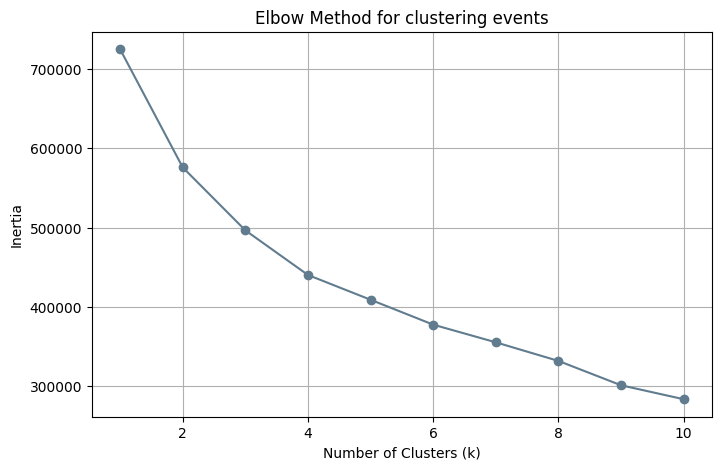

In [123]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
k_range = range(1, 11)

for k in k_range:
    model = KMeans(n_clusters=k, n_init=10, random_state=42)
    model.fit(X_scaled)
    inertia.append(model.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o', color ='#607c8e')
plt.title('Elbow Method for clustering events')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.savefig('/Users/nick/BPPSO/figures/Ebow_plot_performance_II')
plt.show()

In [106]:
#We choose four clusters (Explanation can be found in the report)
chosen_k = 4
final_model = KMeans(n_clusters=chosen_k, n_init=10, random_state=42)

cluster_labels = final_model.fit_predict(X_scaled)

In [107]:
X_activities['Cluster'] = cluster_labels

# Calculate the average values for each cluster
cluster_profile = X_activities.groupby('Cluster').mean()

print(cluster_profile)

concept:name  A_Accepted  A_Cancelled  A_Complete  A_Concept  \
Cluster                                                        
0                    1.0     0.010288    1.000000        1.0   
1                    1.0     0.992916    0.987927        1.0   
2                    1.0     0.075621    1.000000        1.0   
3                    1.0     0.000000    0.993009        1.0   

concept:name  A_Create Application  A_Denied  A_Incomplete  A_Pending  \
Cluster                                                                 
0                              1.0  0.000000      0.964521   0.987896   
1                              1.0  0.001996      0.064758   0.000000   
2                              1.0  0.002858      1.723676   0.916465   
3                              1.0  1.000269      0.488034   0.000000   

concept:name  A_Submitted  A_Validating  ...  O_Sent (mail and online)  \
Cluster                                  ...                             
0                0.559725   

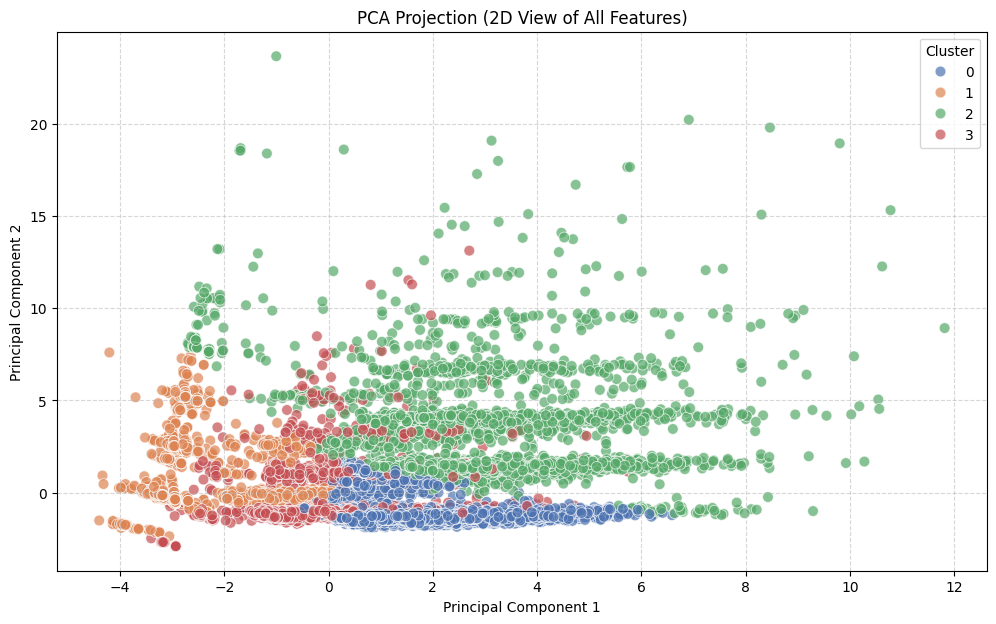

In [108]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X_plot = X_activities.copy()
X_plot['Cluster'] = cluster_labels

fig, axes = plt.subplots(1, 1, figsize=(12, 7))



pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)
X_plot['PCA1'] = pca_components[:, 0]
X_plot['PCA2'] = pca_components[:, 1]

sns.scatterplot(
    data=X_plot, x='PCA1', y='PCA2',
    hue='Cluster', palette='deep', s=60, alpha=0.7, ax=axes
)
axes.set_title('PCA Projection (2D View of All Features)')
axes.set_xlabel('Principal Component 1')
axes.set_ylabel('Principal Component 2')
axes.grid(True, linestyle='--', alpha=0.5)


plt.show()

                                     PC1           PC2
concept:name                                          
A_Accepted                  0.000000e+00  0.000000e+00
A_Cancelled                -3.353652e-01  1.225990e-01
A_Complete                  4.257788e-02  3.255820e-02
A_Concept                  -5.551115e-17  5.551115e-17
A_Create Application        0.000000e+00 -1.110223e-16
A_Denied                   -3.031643e-02 -4.511733e-02
A_Incomplete                3.356060e-01  4.533693e-02
A_Pending                   3.373265e-01 -8.796470e-02
A_Submitted                -6.656827e-02  6.441746e-02
A_Validating                3.812429e-01 -8.166260e-03
O_Accepted                  3.373265e-01 -8.796470e-02
O_Cancelled                -1.137569e-01  4.687120e-01
O_Create Offer              9.114682e-02  4.953400e-01
O_Created                   9.114682e-02  4.953400e-01
O_Refused                  -1.925043e-02  1.351374e-02
O_Returned                  3.574986e-01 -1.862059e-02
O_Sent (ma

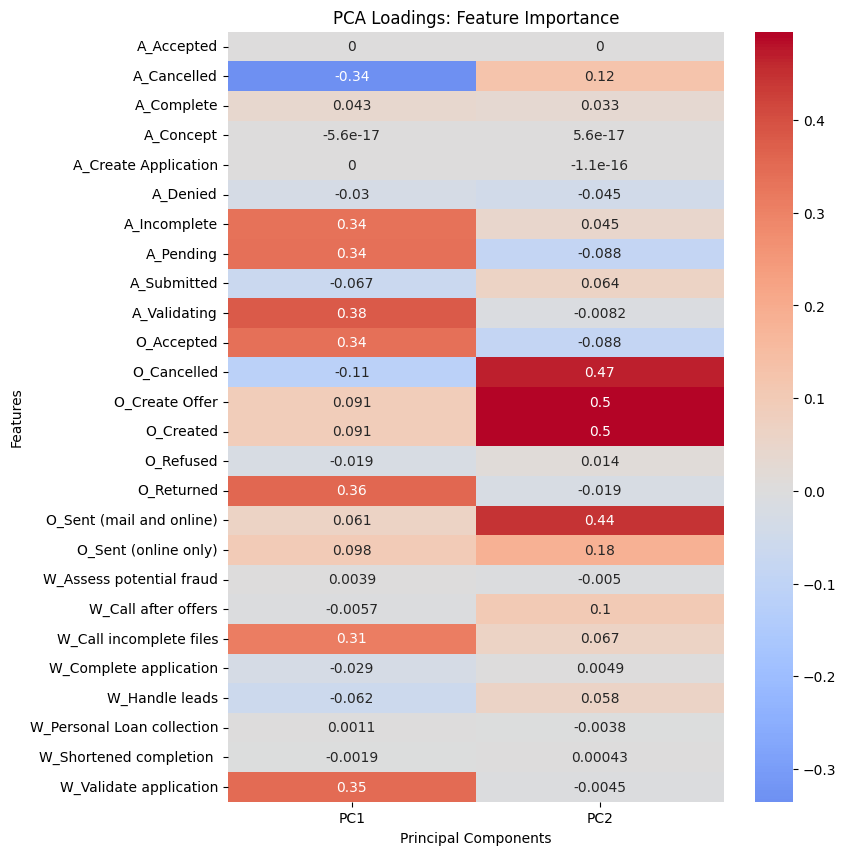

In [117]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


X_plot_2 = X_activities.copy()

feature_names = X_plot_2.drop(columns=['Cluster']).columns

loadings_df = pd.DataFrame(
    pca.components_.T, 
    columns=['PC1', 'PC2'],
    index=feature_names 
)

print(loadings_df)

plt.figure(figsize=(8, 10)) 
sns.heatmap(loadings_df, annot=True, cmap='coolwarm', center=0)
plt.title('PCA Loadings: Feature Importance')
plt.ylabel('Features')
plt.xlabel('Principal Components')
plt.savefig('/Users/nick/BPPSO/figures/cluster_heatmap')
plt.show()

In [118]:
X = X_plot.copy()
X['Trace_Length'] = trace_features_df['Trace_Length']
X['Total_Time_Seconds'] = trace_features_df['Total_Time_Seconds']

X.head()

concept:name,A_Accepted,A_Cancelled,A_Complete,A_Concept,A_Create Application,A_Denied,A_Incomplete,A_Pending,A_Submitted,A_Validating,...,W_Complete application,W_Handle leads,W_Personal Loan collection,W_Shortened completion,W_Validate application,Cluster,PCA1,PCA2,Trace_Length,Total_Time_Seconds
case:concept:name,,,,,,,,,,,,,,,,,,,,,
Application_1000086665,1,1,1,1,1,0,0,0,1,0,...,4,2,0,0,0,1,-3.178559,-0.140049,22,2815395.220
Application_1000158214,1,0,1,1,1,0,0,1,1,1,...,3,2,0,0,4,0,0.253354,-1.501803,25,694054.438
Application_1000311556,1,1,1,1,1,0,0,0,0,0,...,3,0,0,0,0,1,-2.942555,-0.358886,18,2642651.288
Application_1000334415,1,0,1,1,1,1,1,0,1,2,...,5,2,0,0,7,3,-0.170752,-1.028111,40,1177576.631
Application_1000339879,1,0,1,1,1,0,2,1,1,3,...,3,2,0,0,16,0,2.582420,-1.223520,51,1109678.441


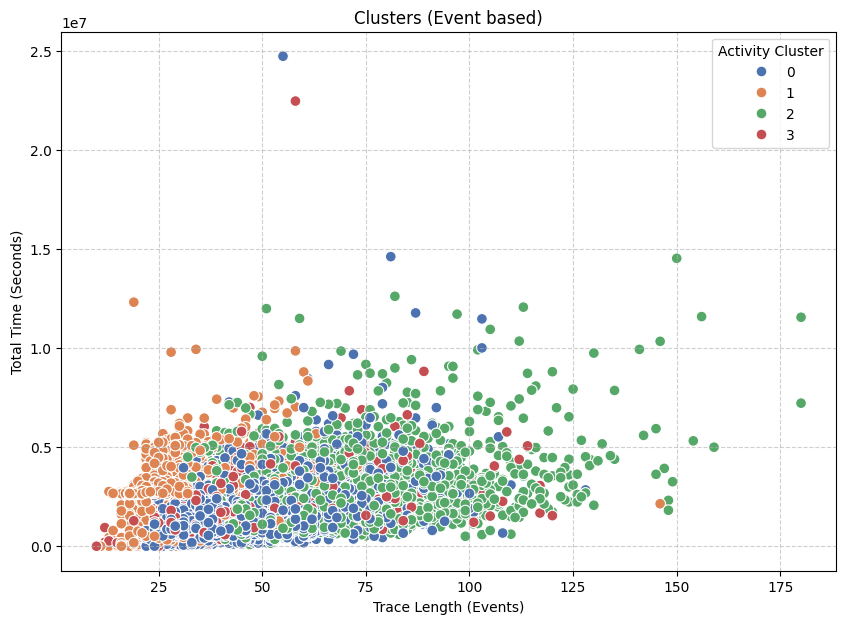

In [119]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 7))

sns.scatterplot(
    data=X, 
    x='Trace_Length',
    y='Total_Time_Seconds',
    hue='Cluster', 
    palette='deep',
    s=60,
    edgecolor='white',            
    linewidth=0.8
)

plt.title('Clusters (Event based)')
plt.xlabel('Trace Length (Events)')
plt.ylabel('Total Time (Seconds)')
plt.legend(title='Activity Cluster')
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('/Users/nick/BPPSO/figures/cluster_mapped_on_length.png')
plt.show()

In [120]:

pca_scores = pca.transform(X_scaled)

num_components = pca_scores.shape[1] 
pca_feature_names = [f'PC{i+1}' for i in range(num_components)]

pca_df = pd.DataFrame(
    pca_scores,
    columns=pca_feature_names
)

In [121]:
from sklearn.cluster import KMeans
import pandas as pd

k_chosen_pca = 4 #

kmeans_pca = KMeans(n_clusters=k_chosen_pca, random_state=42, n_init=10)
pca_cluster_labels = kmeans_pca.fit_predict(pca_df)

X['PCA_Cluster'] = pca_cluster_labels

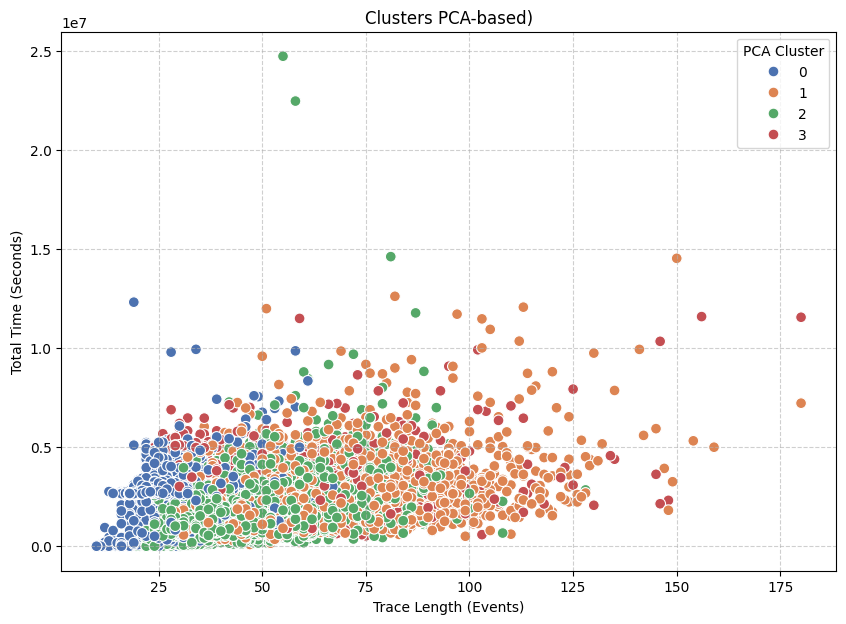

In [122]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

k_clusters = X['PCA_Cluster'].nunique() 

plt.figure(figsize=(10, 7))

sns.scatterplot(
    data=X, 
    x='Trace_Length',
    y='Total_Time_Seconds',
    hue='PCA_Cluster', # The final, most robust cluster labels
    palette='deep', # Use only the necessary number of colors
    s=60,
    edgecolor='white',    # Adds the white border for clarity
    linewidth=0.8
)

plt.title('Clusters PCA-based)')
plt.xlabel('Trace Length (Events)')
plt.ylabel('Total Time (Seconds)')
plt.legend(title='PCA Cluster')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()